## Import the packages

We use pydicom, opencv and lmdb for reading and interpreting DICOM files from the data set.

In [234]:
import cv2, dicom, lmdb, json
import os, random, re, sys, shutil
import fnmatch, subprocess
from IPython.utils import io

from scipy.ndimage import label
from scipy.ndimage.morphology import binary_erosion
from scipy.fftpack import fftn, ifftn
from scipy.signal import argrelmin, correlate
from scipy.spatial.distance import euclidean
from scipy.stats import linregress
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline

import numpy as np
np.random.seed(1234)

from matplotlib import image
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore') # we ignore a RuntimeWarning produced from dividing by zero

CAFFE_ROOT = "/home/ubuntu/caffe"
caffe_path = os.path.join(CAFFE_ROOT, "python")
if caffe_path not in sys.path:
    sys.path.insert(0, caffe_path)

import caffe

print "Successfully imported all packages"

Successfully imported all packages


In [235]:
#
# PARAMETERS
#


# number of bins to use in histogram for gaussian regression
NUM_BINS = 100
# number of standard deviations past which we will consider a pixel an outlier
STD_MULTIPLIER = 2
# number of points of our interpolated dataset to consider when searching for
# a threshold value; the function by default is interpolated over 1000 points,
# so 250 will look at the half of the points that is centered around the known
# myocardium pixel
THRESHOLD_AREA = 250
# number of pixels on the line within which to search for a connected component
# in a thresholded image, increase this to look for components further away
COMPONENT_INDEX_TOLERANCE = 20
# number of angles to search when looking for the correct orientation
ANGLE_SLICES = 36

print "Defined all parameters"

Defined all parameters


## Dataset Class

This class traverses the input data and reads the input data set (DICOM) files.

In [236]:
class Dataset(object):
    dataset_count = 0

    def __init__(self, directory, subdir):
        # deal with any intervening directories
        while True:
            subdirs = next(os.walk(directory))[1]
            if len(subdirs) == 1:
                directory = os.path.join(directory, subdirs[0])
            else:
                break

        slices = []
        for s in subdirs:
            m = re.match("sax_(\d+)", s)
            if m is not None:
                slices.append(int(m.group(1)))

        slices_map = {}
        first = True
        times = []
        for s in slices:
            files = next(os.walk(os.path.join(directory, "sax_%d" % s)))[2]
            offset = None

            for f in files:
                m = re.match("IM-(\d{4,})-(\d{4})\.dcm", f)
                if m is not None:
                    if first:
                        times.append(int(m.group(2)))
                    if offset is None:
                        offset = int(m.group(1))

            first = False
            slices_map[s] = offset

        self.directory = directory
        self.time = sorted(times)
        self.slices = sorted(slices)
        self.slices_map = slices_map
        Dataset.dataset_count += 1
        self.name = subdir

    def _filename(self, s, t):
        return os.path.join(self.directory,"sax_%d" % s, "IM-%04d-%04d.dcm" % (self.slices_map[s], t))

    def _read_dicom_image(self, filename):
        d = dicom.read_file(filename)
        img = d.pixel_array
        return np.array(img)

    def _read_all_dicom_images(self):
        f1 = self._filename(self.slices[0], self.time[0])
        d1 = dicom.read_file(f1)
        (x, y) = d1.PixelSpacing
        (x, y) = (float(x), float(y))
        f2 = self._filename(self.slices[1], self.time[0])
        d2 = dicom.read_file(f2)

        # try a couple of things to measure distance between slices
        try:
            dist = np.abs(d2.SliceLocation - d1.SliceLocation)
        except AttributeError:
            try:
                dist = d1.SliceThickness
            except AttributeError:
                dist = 8  # better than nothing...

        self.images = np.array([[self._read_dicom_image(self._filename(d, i))
                                 for i in self.time]
                                for d in self.slices])
        self.dist = dist
        self.area_multiplier = x * y

    def load(self):
        self._read_all_dicom_images()

## Segment the dataset

In [237]:
# assumes dataset is loaded, call dataset.load()
def segment_dataset(dataset):
    images = dataset.images
    dist = dataset.dist
    areaMultiplier = dataset.area_multiplier
    # shape: num slices, num snapshots, rows, columns
    log("Calculating rois...", 1)
    rois, circles = calc_rois(images)
    log("Calculating areas...", 1)
    all_masks, all_areas = calc_all_areas(images, rois, circles)

    save_masks_to_dir(dataset, all_masks)

In [238]:
def save_masks_to_dir(dataset, all_masks):
    max_masks_to_show = 10
    mask_show = 1
    imgs, labels = [], []
    os.mkdir("output/%s" % dataset.name)
    if os.path.exists("input"):
        shutil.rmtree("input")
    os.mkdir("input")
    os.mkdir("input/%s" % dataset.name)
    for s in range(len(dataset.slices)):
        os.mkdir("output/%s/slice%02d" % (dataset.name, s))
        os.mkdir("input/%s/slice%02d" % (dataset.name, s))
        for t in range(len(dataset.time)):
            mask = all_masks[t][s]
            
            image.imsave("output/%s/slice%02d/time%02d_mask.png" %
                         (dataset.name, s, t), mask)
            img = dataset.images[s][t]
            image.imsave("input/%s/slice%02d/time%02d_DICOM.png" %
                         (dataset.name, s, t), img)
            imgs.append(img.astype(np.int))
            
            label = np.zeros_like(img, dtype="uint8")
            temp = np.where(mask != 0)
            r = temp[0]
            c = temp[1]
            mask = np.column_stack((c, r))
            # mask = np.transpose(np.nonzero(mask))
            cv2.fillPoly(label, [mask], 1)
            labels.append(label)
            
            if mask_show < max_masks_to_show:
                print "<Contour for {0}, image <Slice-{1}, Time-{2}>>".format(dataset.name, s, t)
                plt.imshow(img)
                plt.show()
                plt.imshow(label)
                plt.show()
                mask_show = mask_show + 1
            
        print "# of images: {0}, # of labels: {1}".format(len(imgs), len(labels))

    SPLIT_RATIO = 0.1
    print("Processing validation images")
    export_contours("val", imgs[0:int(SPLIT_RATIO*len(imgs))], labels[0:int(SPLIT_RATIO*len(imgs))])
    print("Processing training images")
    export_contours("train", imgs[int(SPLIT_RATIO*len(imgs)):], labels[int(SPLIT_RATIO*len(imgs)):])
    
def export_contours(t, imgs, labels):
    img_folder = t + "_images_lmdb"
    label_folder = t + "_labels_lmdb"
    for lmdb_name in [img_folder, label_folder]:
        db_path = os.path.abspath(lmdb_name)
        if os.path.exists(db_path):
            shutil.rmtree(db_path)
    counter_img = 0
    counter_label = 0
    batchsz = 100
    print("Processing {:d} images and labels...".format(len(imgs)))
    for i in xrange(int(np.ceil(len(imgs) / float(batchsz)))):
        batch_imgs = imgs[(batchsz*i):(batchsz*(i+1))]
        batch_labels = labels[(batchsz*i):(batchsz*(i+1))]
        if len(batch_imgs) == 0:
            break
        db_imgs = lmdb.open(img_folder, map_size=1e12)
        with db_imgs.begin(write=True) as txn_img:          
            for img in batch_imgs:
                datum = caffe.io.array_to_datum(np.expand_dims(img, axis=0))
                txn_img.put("{:0>10d}".format(counter_img), datum.SerializeToString())
                counter_img += 1
        print("Processed {:d} images".format(counter_img))
        db_labels = lmdb.open(label_folder, map_size=1e12)
        with db_labels.begin(write=True) as txn_label:
            for lbl in batch_labels:
                datum = caffe.io.array_to_datum(np.expand_dims(lbl, axis=0))
                txn_label.put("{:0>10d}".format(counter_label), datum.SerializeToString())
                counter_label += 1
        print("Processed {:d} labels".format(counter_label))

In [239]:
def calc_rois(images):
    (num_slices, _, _, _) = images.shape
    log("Calculating mean...", 2)
    dc = np.mean(images, 1)

    def get_H1(i):
        # log("Fourier transforming on slice %d..." % i, 3)
        ff = fftn(images[i])
        # print "ff"+str(np.shape(ff))
        first_harmonic = ff[1, :, :]
        # print "first_harmonic"+str(np.shape(first_harmonic))
        # log("Inverse Fourier transforming on slice %d..." % i, 3)
        result = np.absolute(ifftn(first_harmonic))
        # log("Performing Gaussian blur on slice %d..." % i, 3)
        result = cv2.GaussianBlur(result, (5, 5), 0)
        # print "result" + str(np.shape(result))
        return result

    log("Performing Fourier transforms...", 2)
    h1s = np.array([get_H1(i) for i in range(num_slices)])
    # print "h1s" + str(np.shape(h1s))
    m = np.max(h1s) * 0.05
    h1s[h1s < m] = 0

    log("Applying regression filter...", 2)
    regress_h1s = regression_filter(h1s)
    log("Post-processing filtered images...", 2)
    proc_regress_h1s, coords = post_process_regression(regress_h1s)
    log("Determining ROIs...", 2)
    rois, circles = get_ROIs(dc, proc_regress_h1s, coords)
    return rois, circles


def calc_all_areas(images, rois, circles):
    closest_slice = get_closest_slice(rois)
    (_, times, _, _) = images.shape

    def calc_areas(time):
        # log("Calculating areas at time %d..." % time, 2)
        mask, mean = locate_lv_blood_pool(images, rois, circles, closest_slice,
                                          time)
        masks, areas = propagate_segments(images, rois, mask, mean,
                                          closest_slice, time)
        return (masks, areas)

    result = np.transpose(map(calc_areas, range(times)))
    all_masks = result[0]
    all_areas = result[1]
    return all_masks, all_areas


def calc_total_volume(areas, area_multiplier, dist):
    slices = np.array(sorted(areas.keys()))
    modified = [areas[i] * area_multiplier for i in slices]
    vol = 0
    for i in slices[:-1]:
        a, b = modified[i], modified[i+1]
        subvol = (dist/3.0) * (a + np.sqrt(a*b) + b)
        vol += subvol / 1000.0  # conversion to mL
    return vol


def get_centroid(img):
    nz = np.nonzero(img)
    pxls = np.transpose(nz)
    weights = img[nz]
    avg = np.average(pxls, axis=0, weights=weights)
    return avg


def regress_centroids(cs):
    num_slices = len(cs)
    y_centroids = cs[:, 0]
    x_centroids = cs[:, 1]
    z_values = np.array(range(num_slices))

    (xslope, xintercept, _, _, _) = linregress(z_values, x_centroids)
    (yslope, yintercept, _, _, _) = linregress(z_values, y_centroids)

    return (xslope, xintercept, yslope, yintercept)


def get_weighted_distances(imgs, coords, xs, xi, ys, yi):
    a = np.array([0, yi, xi])
    n = np.array([1, ys, xs])

    zeros = np.zeros(3)

    def dist(p):
        to_line = (a - p) - (np.dot((a - p), n) * n)
        d = euclidean(zeros, to_line)
        return d

    def weight(p):
        (z, y, x) = p
        return imgs[z, y, x]

    dists = np.array([dist(c) for c in coords])
    weights = np.array([weight(c) for c in coords])
    return (coords, dists, weights)


def gaussian_fit(dists, weights):
    # based on http://stackoverflow.com/questions/11507028/fit-a-gaussian-function
    (x, y) = histogram_transform(dists, weights)
    fivep = int(len(x) * 0.05)
    xtmp = x
    ytmp = y
    fromFront = False
    while True:
        if len(xtmp) == 0 and len(ytmp) == 0:
            if fromFront:
                # well we failed
                idx = np.argmax(y)
                xmax = x[idx]
                p0 = [max(y), xmax, xmax]
                (A, mu, sigma) = p0
                return mu, sigma, lambda x: gauss(x, A, mu, sigma)
            else:
                fromFront = True
                xtmp = x
                ytmp = y

        idx = np.argmax(ytmp)
        xmax = xtmp[idx]

        def gauss(x, *p):
            A, mu, sigma = p
            return A*np.exp(-(x-mu)**2/(2.*sigma**2))

        p0 = [max(ytmp), xmax, xmax]
        try:
            coeff, var_matrix = curve_fit(gauss, xtmp, ytmp, p0=p0)
            (A, mu, sigma) = coeff
            return (mu, sigma, lambda x: gauss(x, A, mu, sigma))
        except RuntimeError:
            if fromFront:
                xtmp = xtmp[fivep:]
                ytmp = ytmp[fivep:]
            else:
                xtmp = xtmp[:-fivep]
                ytmp = ytmp[:-fivep]


def histogram_transform(values, weights):
    hist, bins = np.histogram(values, bins=NUM_BINS, weights=weights)
    bin_width = bins[1] - bins[0]
    bin_centers = bins[:-1] + (bin_width / 2)

    return (bin_centers, hist)


def get_outliers(coords, dists, weights):
    fivep = int(len(weights) * 0.05)
    ctr = 1
    while True:
        (mean, std, fn) = gaussian_fit(dists, weights)
        low_values = dists < (mean - STD_MULTIPLIER*np.abs(std))
        high_values = dists > (mean + STD_MULTIPLIER*np.abs(std))
        outliers = np.logical_or(low_values, high_values)
        if len(coords[outliers]) == len(coords):
            weights[-fivep*ctr:] = 0
            ctr += 1
        else:
            return coords[outliers]


def regress_and_filter_distant(imgs):
    centroids = np.array([get_centroid(img) for img in imgs])
    raw_coords = np.transpose(np.nonzero(imgs))
    (xslope, xintercept, yslope, yintercept) = regress_centroids(centroids)
    (coords, dists, weights) = get_weighted_distances(imgs, raw_coords, xslope,
                                                      xintercept, yslope,
                                                      yintercept)
    outliers = get_outliers(coords, dists, weights)
    imgs_cpy = np.copy(imgs)
    for c in outliers:
        (z, x, y) = c
        imgs_cpy[z, x, y] = 0
    return imgs_cpy


def regression_filter(imgs):
    condition = True
    iternum = 0
    while(condition):
        # log("Beginning iteration %d of regression..." % iternum, 3)
        iternum += 1
        imgs_filtered = regress_and_filter_distant(imgs)
        c1 = get_centroid(imgs)
        print "c1" + str(c1)
        c2 = get_centroid(imgs_filtered)
        dc = np.linalg.norm(c1 - c2)
        imgs = imgs_filtered
        condition = (dc > 1.0)  # because python has no do-while loops
    return imgs


def post_process_regression(imgs):
    (numimgs, _, _) = imgs.shape
    centroids = np.array([get_centroid(img) for img in imgs])
    log("Performing final centroid regression...", 3)
    (xslope, xintercept, yslope, yintercept) = regress_centroids(centroids)
    imgs_cpy = np.copy(imgs)

    def filter_one_img(zlvl):
        points_on_zlvl = np.transpose(imgs[zlvl].nonzero())
        points_on_zlvl = np.insert(points_on_zlvl, 0, zlvl, axis=1)
        (coords, dists, weights) = get_weighted_distances(imgs, points_on_zlvl,
                                                          xslope, xintercept,
                                                          yslope, yintercept)
        outliers = get_outliers(coords, dists, weights)
        for c in outliers:
            (z, x, y) = c
            imgs_cpy[z, x, y] = 0

    log("Final image filtering...", 3)
    for z in range(numimgs):
        # log("Filtering image %d of %d..." % (z+1, numimgs), 4)
        filter_one_img(z)

    return (imgs_cpy, (xslope, xintercept, yslope, yintercept))


def floats_draw_circle(img, center, r, color, thickness):
    (x, y) = center
    x, y = int(np.round(x)), int(np.round(y))
    r = int(np.round(r))
    cv2.circle(img, center=(x, y), radius=r, color=color, thickness=thickness)


def filled_ratio_of_circle(img, center, r):
    mask = np.zeros_like(img)
    floats_draw_circle(mask, center, r, 1, -1)
    masked = mask * img
    (x, _) = np.nonzero(mask)
    (x2, _) = np.nonzero(masked)
    if x.size == 0:
        return 0
    return float(x2.size) / x.size


def circle_smart_radius(img, center):
    domain = np.arange(1, 100)
    (xintercept, yintercept) = center

    def ratio(r):
        return filled_ratio_of_circle(img, (xintercept, yintercept), r)*r

    y = np.array([ratio(d) for d in domain])
    most = np.argmax(y)
    return domain[most]


def get_ROIs(originals, h1s, regression_params):
    (xslope, xintercept, yslope, yintercept) = regression_params
    (num_slices, _, _) = h1s.shape
    results = []
    circles = []
    for i in range(num_slices):
        # log("Getting ROI in slice %d..." % i, 3)
        o = originals[i]
        h = h1s[i]
        ctr = (xintercept + xslope * i, yintercept + yslope * i)
        r = circle_smart_radius(h, ctr)
        tmp = np.zeros_like(o)
        floats_draw_circle(tmp, ctr, r, 1, -1)
        results.append(tmp * o)
        circles.append((ctr, r))

    return (np.array(results), np.array(circles))


def bresenham(x0, x1, y0, y1, fn):
    # using some pseudocode from
    # https://en.wikipedia.org/wiki/Xiaolin_Wu%27s_line_algorithm
    # and also https://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm
    steep = abs(y1-y0) > abs(x1-x0)
    if steep:
        x0, x1, y0, y1 = y0, y1, x0, x1
    if x0 > x1:
        x0, x1, y0, y1 = x1, x0, y1, y0

    def plot(x, y):
        if steep:
            fn(y, x)
        else:
            fn(x, y)

    dx = x1 - x0
    dy = y1 - y0

    D = 2*np.abs(dy) - dx
    plot(x0, y0)
    y = y0

    for x in range(x0+1, x1+1):  # x0+1 to x1
        D = D + 2*np.abs(dy)
        if D > 0:
            y += np.sign(dy)
            D -= 2*dx
        plot(x, y)


def line_thru(bounds, center, theta):
    (xmin, xmax, ymin, ymax) = bounds
    (cx, cy) = center

    if np.cos(theta) == 0:
        return (cx, ymin, cx, ymax)
    slope = np.tan(theta)

    x0 = xmin
    y0 = cy - (cx - xmin) * slope
    if y0 < ymin:
        y0 = ymin
        x0 = max(xmin, cx - ((cy - ymin) / slope))
    elif y0 > ymax:
        y0 = ymax
        x0 = max(xmin, cx - ((cy - ymax) / slope))

    x1 = xmax
    y1 = cy + (xmax - cx) * slope
    if y1 < ymin:
        y1 = ymin
        x1 = min(xmax, cx + ((ymin - cy) / slope))
    elif y1 > ymax:
        y1 = ymax
        x1 = min(xmax, cx + ((ymax - cy) / slope))

    return (x0, x1, y0, y1)


def get_line_coords(w, h, cx, cy, theta):
    coords = np.floor(np.array(line_thru((0, w-1, 0, h-1), (cx, cy), theta)))
    return coords.astype(np.int)


def trim_zeros_indices(has_zeros):
    first = 0
    for i in has_zeros:
        if i == 0:
            first += 1
        else:
            break

    last = len(has_zeros)
    for i in has_zeros[::-1]:
        if i == 0:
            last -= 1
        else:
            break

    return first, last


def get_line(roi, cx, cy, theta):
    (h, w) = roi.shape
    (x0, x1, y0, y1) = get_line_coords(w, h, cx, cy, theta)

    intensities = []
    coords = []

    def collect(x, y):
        if y < 0 or y >= h or x < 0 or x >= w:
            return
        intensities.append(roi[y, x])
        coords.append((x, y))

    bresenham(x0, x1, y0, y1, collect)

    def geti(idx):
        return intensities[idx]

    getiv = np.vectorize(geti)
    x = np.arange(0, len(intensities))
    y = getiv(x)
    first, last = trim_zeros_indices(y)
    trimy = y[first:last]
    trimcoords = coords[first:last]

    trimx = np.arange(0, trimy.size)
    return (trimx, trimy, trimcoords)


def find_best_angle(roi, circ):
    ((cx, cy), r) = circ
    results = np.zeros(ANGLE_SLICES)
    fns = [None for i in range(ANGLE_SLICES)]

    COS_MATCHED_FILTER_FREQ = 2.5

    def score_matched(trimx, trimy):
        # first, normalize this data
        newtrimx = np.linspace(0.0, 1.0, np.size(trimx))
        minimum = np.min(trimy)
        maximum = np.max(trimy) - minimum
        newtrimy = (trimy - minimum) / maximum

        filt = 1 - ((np.cos(COS_MATCHED_FILTER_FREQ*2*np.pi*newtrimx)) /
                    2 + (0.5))
        cr = correlate(newtrimy, filt, mode="same")
        return np.max(cr)

    for i in range(ANGLE_SLICES):
        trimx, trimy, trimcoords = get_line(roi, cx, cy, np.pi*i/ANGLE_SLICES)
        score2 = score_matched(trimx, trimy)
        results[i] = score2
        fns[i] = (UnivariateSpline(trimx, trimy), trimx, trimcoords)

    best = np.argmax(results)
    return (best * np.pi / ANGLE_SLICES, fns[best])


def find_threshold_point(best, best_fn):
    fn, trimx, trim_coords = best_fn
    dom = np.linspace(np.min(trimx), np.max(trimx), 1000)
    f = fn(dom)
    mins = argrelmin(f)

    closest_min = -1
    closest_dist = -1
    for m in np.nditer(mins):
        dist = np.abs(500 - m)
        if closest_min == -1 or closest_dist > dist:
            closest_min = m
            closest_dist = dist

    fnprime = fn.derivative()
    restrict = dom[np.max(closest_min-THRESHOLD_AREA, 0):
                   closest_min+THRESHOLD_AREA]
    f2 = fnprime(restrict)

    m1 = restrict[np.argmax(f2)]
    mean = fn(m1)

    idx = np.min([int(np.floor(m1))+1, len(trim_coords)-1])
    return (mean, trim_coords, idx)


def get_closest_slice(rois):
    ctrd = get_centroid(rois)
    closest_slice = int(np.round(ctrd[0]))
    return closest_slice


def locate_lv_blood_pool(images, rois, circles, closest_slice, time):
    best, best_fn = find_best_angle(rois[closest_slice],
                                    circles[closest_slice])
    mean, coords, idx = find_threshold_point(best, best_fn)
    thresh, img_bin = cv2.threshold(images[closest_slice,
                                           time].astype(np.float32),
                                    mean, 255.0, cv2.THRESH_BINARY)
    labeled, num = label(img_bin)
    x, y = coords[idx]

    count = 0
    # Look along the line for a component. If one isn't found within a certain
    # number of indices, just spit out the original coordinate.
    while labeled[y][x] == 0:
        idx += 1
        count += 1
        x, y = coords[idx]
        if count > COMPONENT_INDEX_TOLERANCE:
            idx -= count
            x, y = coords[idx]
            break

    if count <= COMPONENT_INDEX_TOLERANCE:
        component = np.transpose(np.nonzero(labeled == labeled[y][x]))
    else:
        component = np.array([[y, x]])

    hull = cv2.convexHull(component)
    squeezed = hull
    if count <= COMPONENT_INDEX_TOLERANCE:
        squeezed = np.squeeze(squeezed)
    hull = np.fliplr(squeezed)

    mask = np.zeros_like(labeled)
    cv2.drawContours(mask, [hull], 0, 255, thickness=-1)
    return mask, mean


def propagate_segments(images, rois, base_mask, mean, closest_slice, time):
    def propagate_segment(i, mask):
        thresh, img_bin = cv2.threshold(images[i,
                                               time].astype(np.float32),
                                        mean, 255.0, cv2.THRESH_BINARY)

        labeled, features = label(img_bin)

        region1 = mask == 255
        max_similar = -1
        max_region = 0
        for j in range(1, features+1):
            region2 = labeled == j
            intersect = np.count_nonzero(np.logical_and(region1, region2))
            union = np.count_nonzero(np.logical_or(region1, region2))
            similar = float(intersect) / union
            if max_similar == -1 or max_similar < similar:
                max_similar = similar
                max_region = j

        if max_similar == 0:
            component = np.transpose(np.nonzero(mask))
        else:
            component = np.transpose(np.nonzero(labeled == max_region))
        hull = cv2.convexHull(component)
        hull = np.squeeze(hull)
        if hull.shape == (2L,):
            hull = np.array([hull])
        hull = np.fliplr(hull)

        newmask = np.zeros_like(img_bin)

        cv2.drawContours(newmask, [hull], 0, 255, thickness=-1)

        return newmask

    (rois_depth, _, _) = rois.shape
    newmask = base_mask
    masks = {}
    areas = {}
    masks[closest_slice] = base_mask
    areas[closest_slice] = np.count_nonzero(base_mask)
    for i in range(closest_slice-1, -1, -1):
        newmask = propagate_segment(i, newmask)
        masks[i] = newmask
        areas[i] = np.count_nonzero(newmask)

    newmask = base_mask
    for i in range(closest_slice+1, rois_depth):
        newmask = propagate_segment(i, newmask)
        masks[i] = newmask
        areas[i] = np.count_nonzero(newmask)

    return masks, areas

In [240]:
def log(msg, lvl):
    string = ""
    for i in range(lvl):
        string += " "
    string += msg
    print string


def auto_segment_all_datasets(dir, num_samples):
    studies = next(os.walk(os.path.join(dir, "train")))[1] + next(
        os.walk(os.path.join(dir, "validate")))[1]
    
    studies = random.sample(studies, num_samples)
    
    if os.path.exists("output"):
        shutil.rmtree("output")
    os.mkdir("output")

    for s in studies:
        if int(s) <= 500:
            full_path = os.path.join(dir, "train", s)
        else:
            full_path = os.path.join(dir, "validate", s)

        dset = Dataset(full_path, s)
        print "Processing dataset %s..." % dset.name
        try:
            dset.load()
            segment_dataset(dset)
        except Exception as e:
            log("***ERROR***: Exception %s thrown by dataset %s" % (str(e), dset.name), 0)

## Run the code

We provide the input directory which has the train and validation data

Processing dataset 443...
 Calculating rois...
  Calculating mean...
  Performing Fourier transforms...
   Fourier transforming on slice 0...
ff(30, 256, 192)
first_harmonic(256, 192)
   Inverse Fourier transforming on slice 0...
   Performing Gaussian blur on slice 0...
result(256, 192)
   Fourier transforming on slice 1...
ff(30, 256, 192)
first_harmonic(256, 192)
   Inverse Fourier transforming on slice 1...
   Performing Gaussian blur on slice 1...
result(256, 192)
   Fourier transforming on slice 2...
ff(30, 256, 192)
first_harmonic(256, 192)
   Inverse Fourier transforming on slice 2...
   Performing Gaussian blur on slice 2...
result(256, 192)
   Fourier transforming on slice 3...
ff(30, 256, 192)
first_harmonic(256, 192)
   Inverse Fourier transforming on slice 3...
   Performing Gaussian blur on slice 3...
result(256, 192)
   Fourier transforming on slice 4...
ff(30, 256, 192)
first_harmonic(256, 192)
   Inverse Fourier transforming on slice 4...
   Performing Gaussian blur on

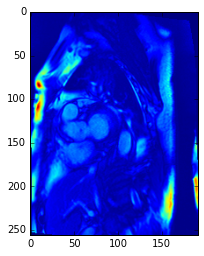

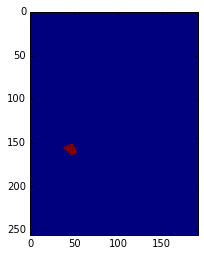

<Contour for 443, image <Slice-0, Time-1>>


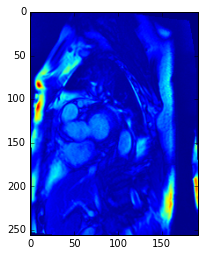

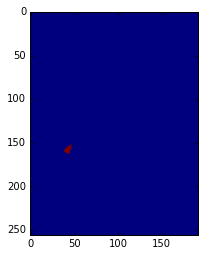

<Contour for 443, image <Slice-0, Time-2>>


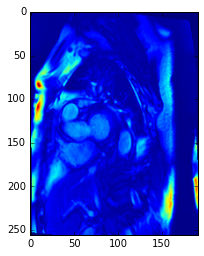

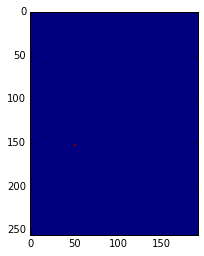

<Contour for 443, image <Slice-0, Time-3>>


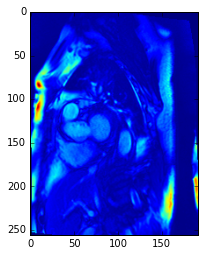

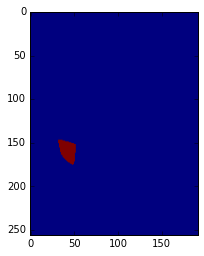

<Contour for 443, image <Slice-0, Time-4>>


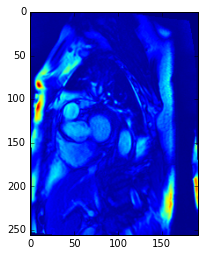

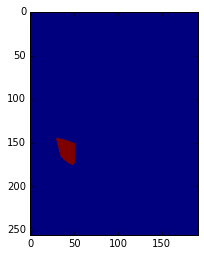

<Contour for 443, image <Slice-0, Time-5>>


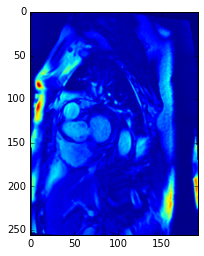

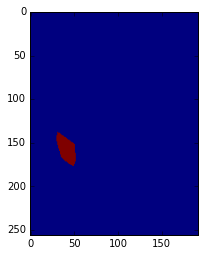

<Contour for 443, image <Slice-0, Time-6>>


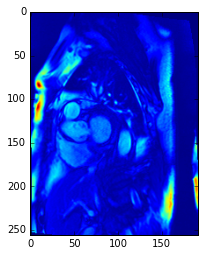

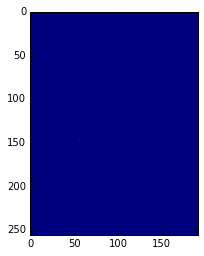

<Contour for 443, image <Slice-0, Time-7>>


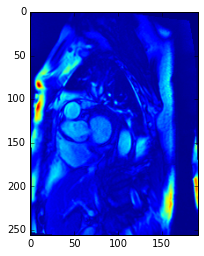

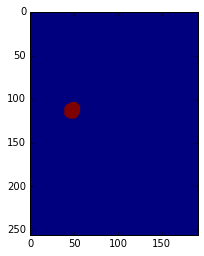

<Contour for 443, image <Slice-0, Time-8>>


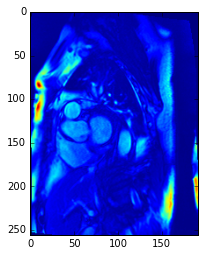

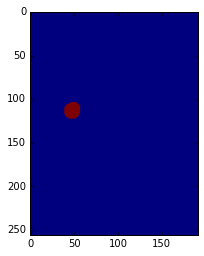

# of images: 30, # of labels: 30
# of images: 60, # of labels: 60
# of images: 90, # of labels: 90
# of images: 120, # of labels: 120
# of images: 150, # of labels: 150
# of images: 180, # of labels: 180
# of images: 210, # of labels: 210
# of images: 240, # of labels: 240
# of images: 270, # of labels: 270
# of images: 300, # of labels: 300
Processing validation images
Processing 30 images and labels...
Processed 30 images
Processed 30 labels
Processing training images
Processing 270 images and labels...
Processed 100 images
Processed 100 labels
Processed 200 images
Processed 200 labels
Processed 270 images
Processed 270 labels
Processing dataset 290...
 Calculating rois...
  Calculating mean...
  Performing Fourier transforms...
   Fourier transforming on slice 0...
ff(30, 256, 192)
first_harmonic(256, 192)
   Inverse Fourier transforming on slice 0...
   Performing Gaussian blur on slice 0...
result(256, 192)
   Fourier transforming on slice 1...
ff(30, 256, 192)
first_harmonic(256,

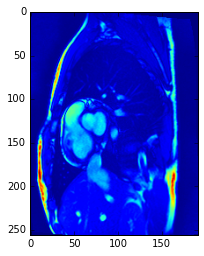

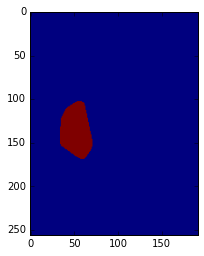

<Contour for 290, image <Slice-0, Time-1>>


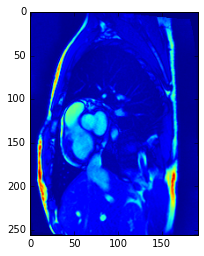

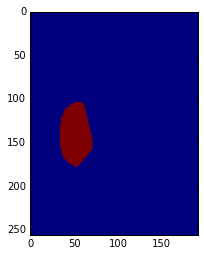

<Contour for 290, image <Slice-0, Time-2>>


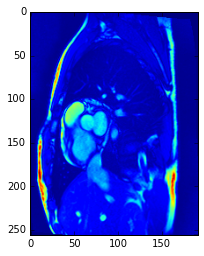

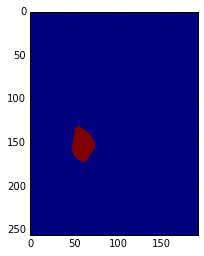

<Contour for 290, image <Slice-0, Time-3>>


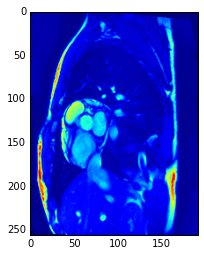

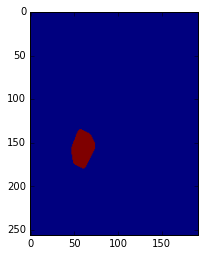

<Contour for 290, image <Slice-0, Time-4>>


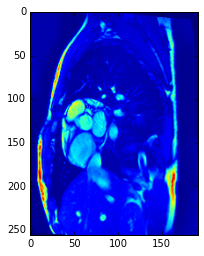

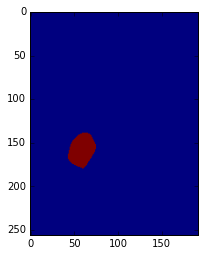

<Contour for 290, image <Slice-0, Time-5>>


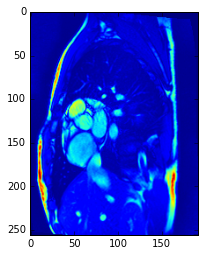

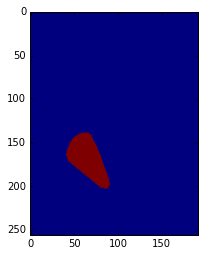

<Contour for 290, image <Slice-0, Time-6>>


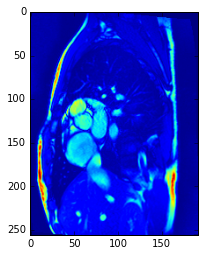

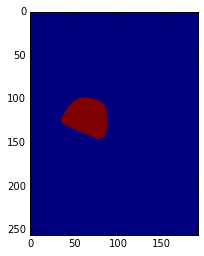

<Contour for 290, image <Slice-0, Time-7>>


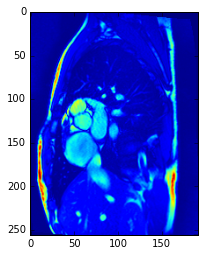

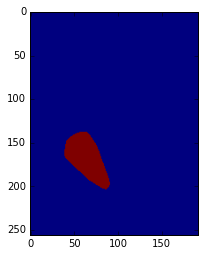

<Contour for 290, image <Slice-0, Time-8>>


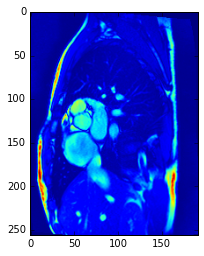

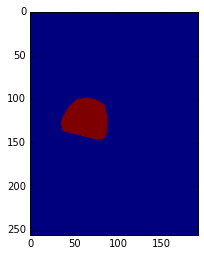

# of images: 30, # of labels: 30
# of images: 60, # of labels: 60
# of images: 90, # of labels: 90
# of images: 120, # of labels: 120
# of images: 150, # of labels: 150
# of images: 180, # of labels: 180
# of images: 210, # of labels: 210
# of images: 240, # of labels: 240
# of images: 270, # of labels: 270
# of images: 300, # of labels: 300
Processing validation images
Processing 30 images and labels...
Processed 30 images
Processed 30 labels
Processing training images
Processing 270 images and labels...
Processed 100 images
Processed 100 labels
Processed 200 images
Processed 200 labels
Processed 270 images
Processed 270 labels
Processing dataset 378...
 Calculating rois...
  Calculating mean...
  Performing Fourier transforms...
   Fourier transforming on slice 0...
ff(30, 256, 256)
first_harmonic(256, 256)
   Inverse Fourier transforming on slice 0...
   Performing Gaussian blur on slice 0...
result(256, 256)
   Fourier transforming on slice 1...
ff(30, 256, 256)
first_harmonic(256,

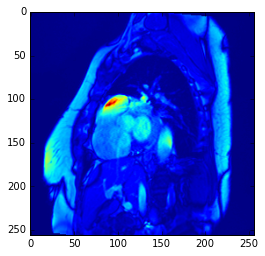

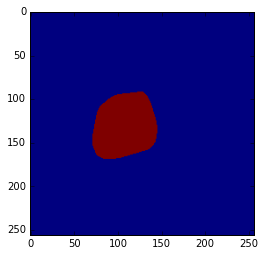

<Contour for 378, image <Slice-0, Time-1>>


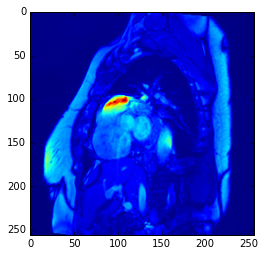

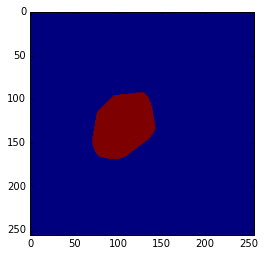

<Contour for 378, image <Slice-0, Time-2>>


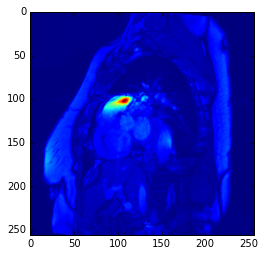

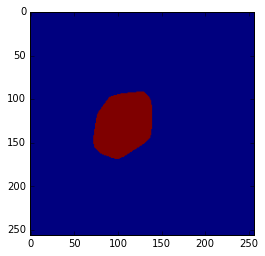

<Contour for 378, image <Slice-0, Time-3>>


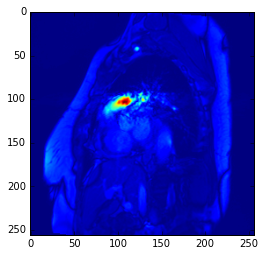

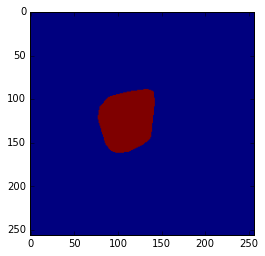

<Contour for 378, image <Slice-0, Time-4>>


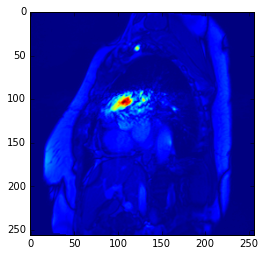

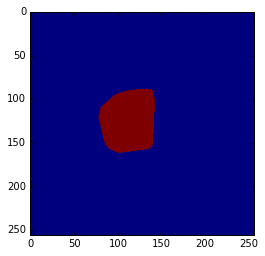

<Contour for 378, image <Slice-0, Time-5>>


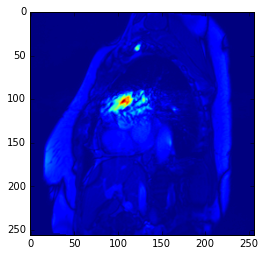

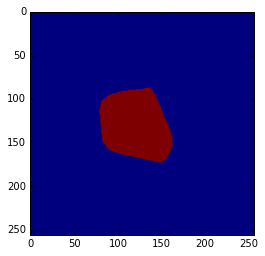

<Contour for 378, image <Slice-0, Time-6>>


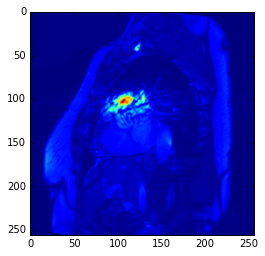

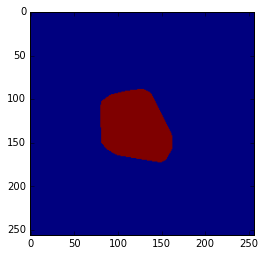

<Contour for 378, image <Slice-0, Time-7>>


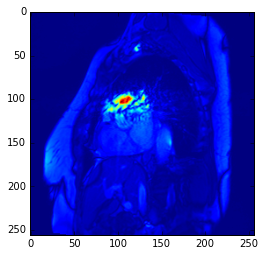

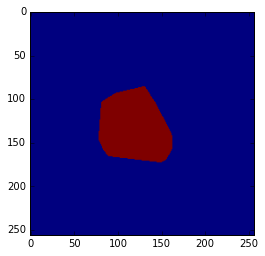

<Contour for 378, image <Slice-0, Time-8>>


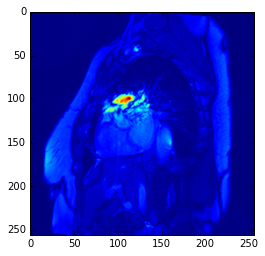

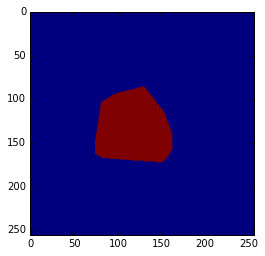

# of images: 30, # of labels: 30
# of images: 60, # of labels: 60
# of images: 90, # of labels: 90
# of images: 120, # of labels: 120
# of images: 150, # of labels: 150
# of images: 180, # of labels: 180
# of images: 210, # of labels: 210
# of images: 240, # of labels: 240
# of images: 270, # of labels: 270
# of images: 300, # of labels: 300
Processing validation images
Processing 30 images and labels...
Processed 30 images
Processed 30 labels
Processing training images
Processing 270 images and labels...
Processed 100 images
Processed 100 labels
Processed 200 images
Processed 200 labels
Processed 270 images
Processed 270 labels
Processing dataset 424...
 Calculating rois...
  Calculating mean...
  Performing Fourier transforms...
   Fourier transforming on slice 0...
ff(30, 192, 256)
first_harmonic(192, 256)
   Inverse Fourier transforming on slice 0...
   Performing Gaussian blur on slice 0...
result(192, 256)
   Fourier transforming on slice 1...
ff(30, 192, 256)
first_harmonic(192,

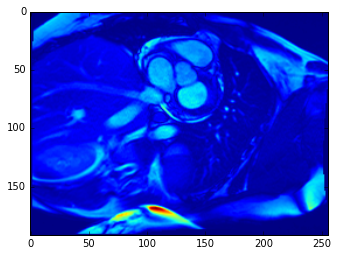

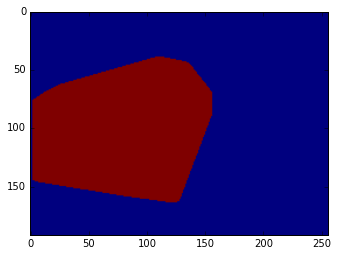

<Contour for 424, image <Slice-0, Time-1>>


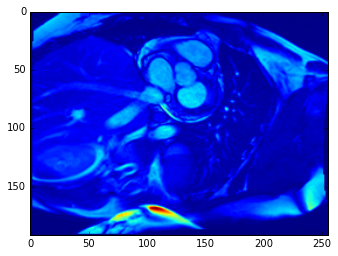

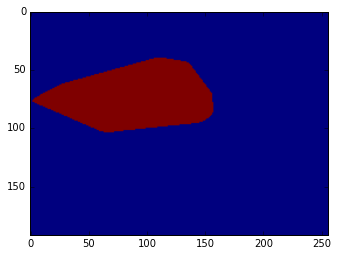

<Contour for 424, image <Slice-0, Time-2>>


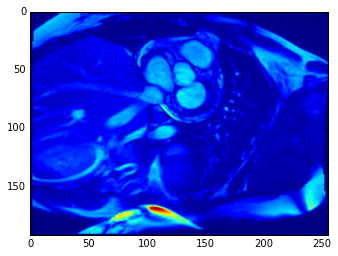

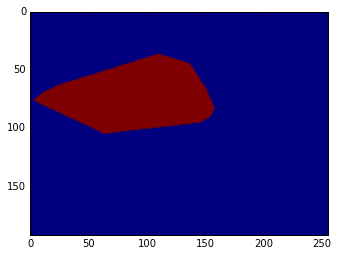

<Contour for 424, image <Slice-0, Time-3>>


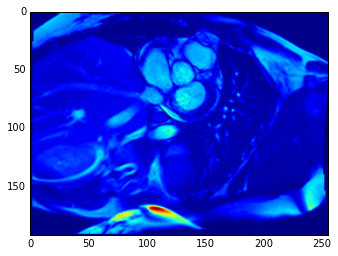

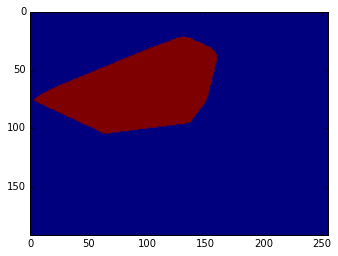

<Contour for 424, image <Slice-0, Time-4>>


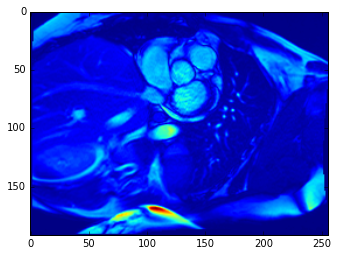

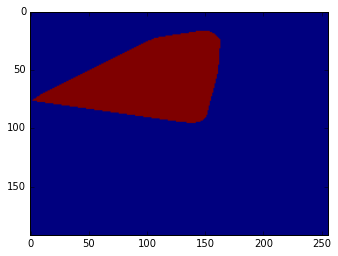

<Contour for 424, image <Slice-0, Time-5>>


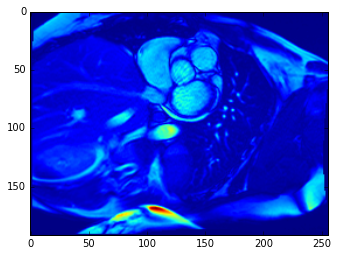

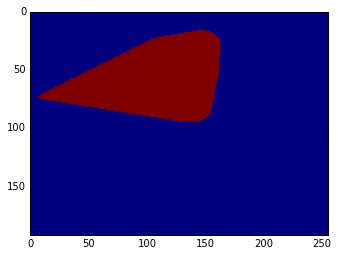

<Contour for 424, image <Slice-0, Time-6>>


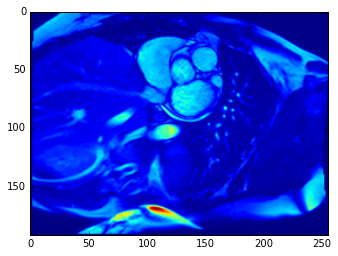

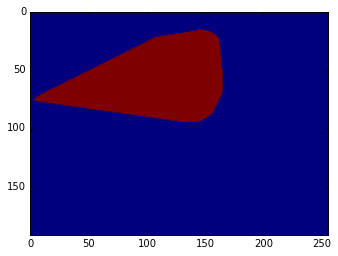

<Contour for 424, image <Slice-0, Time-7>>


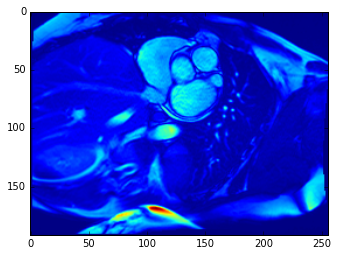

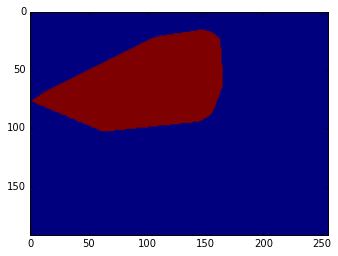

<Contour for 424, image <Slice-0, Time-8>>


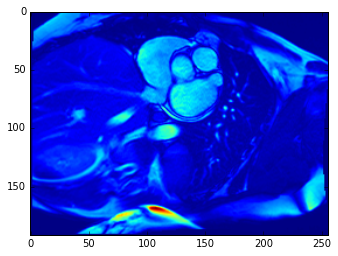

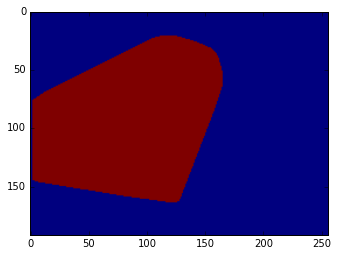

# of images: 30, # of labels: 30
# of images: 60, # of labels: 60
# of images: 90, # of labels: 90
# of images: 120, # of labels: 120
# of images: 150, # of labels: 150
# of images: 180, # of labels: 180
# of images: 210, # of labels: 210
# of images: 240, # of labels: 240
# of images: 270, # of labels: 270
Processing validation images
Processing 27 images and labels...
Processed 27 images
Processed 27 labels
Processing training images
Processing 243 images and labels...
Processed 100 images
Processed 100 labels
Processed 200 images
Processed 200 labels
Processed 243 images
Processed 243 labels
Processing dataset 237...
 Calculating rois...
  Calculating mean...
  Performing Fourier transforms...
   Fourier transforming on slice 0...
ff(30, 608, 456)
first_harmonic(608, 456)
   Inverse Fourier transforming on slice 0...
   Performing Gaussian blur on slice 0...
result(608, 456)
   Fourier transforming on slice 1...
ff(30, 608, 456)
first_harmonic(608, 456)
   Inverse Fourier transformi

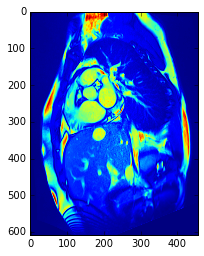

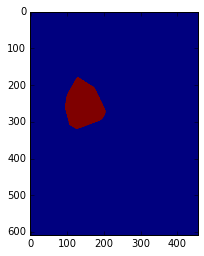

<Contour for 237, image <Slice-0, Time-1>>


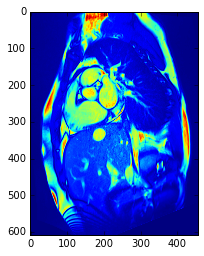

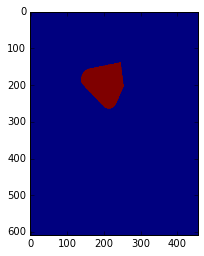

<Contour for 237, image <Slice-0, Time-2>>


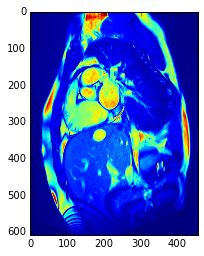

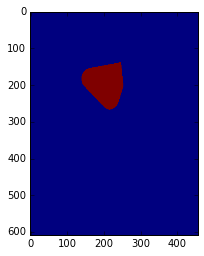

<Contour for 237, image <Slice-0, Time-3>>


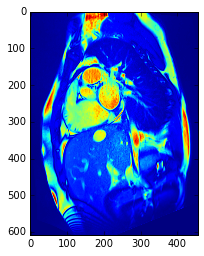

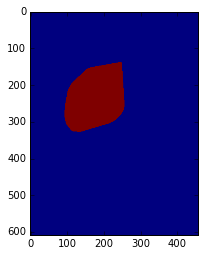

<Contour for 237, image <Slice-0, Time-4>>


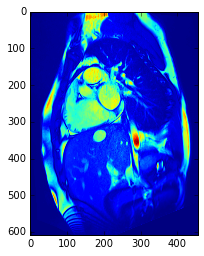

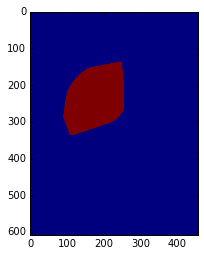

<Contour for 237, image <Slice-0, Time-5>>


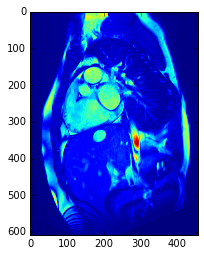

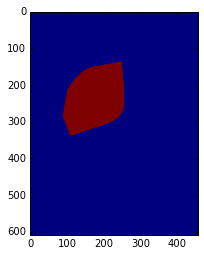

<Contour for 237, image <Slice-0, Time-6>>


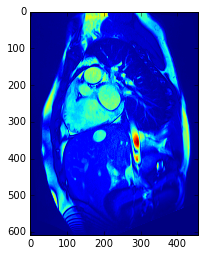

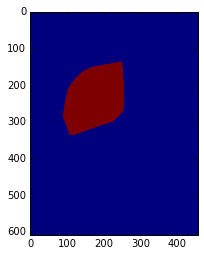

<Contour for 237, image <Slice-0, Time-7>>


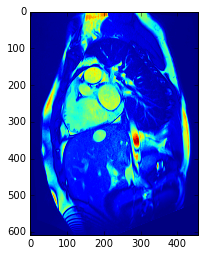

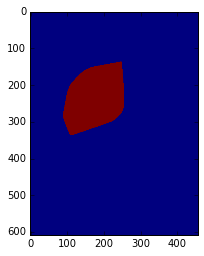

<Contour for 237, image <Slice-0, Time-8>>


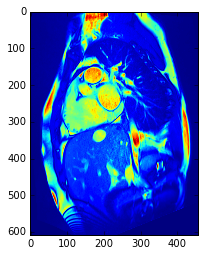

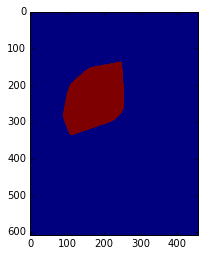

# of images: 30, # of labels: 30
# of images: 60, # of labels: 60
# of images: 90, # of labels: 90
# of images: 120, # of labels: 120
# of images: 150, # of labels: 150
# of images: 180, # of labels: 180
# of images: 210, # of labels: 210
# of images: 240, # of labels: 240
# of images: 270, # of labels: 270
# of images: 300, # of labels: 300
# of images: 330, # of labels: 330
Processing validation images
Processing 33 images and labels...
Processed 33 images
Processed 33 labels
Processing training images
Processing 297 images and labels...
Processed 100 images
Processed 100 labels
Processed 200 images
Processed 200 labels
Processed 297 images
Processed 297 labels


In [241]:
input_dir = "/mnt/data"
num_samples = 100

auto_segment_all_datasets(input_dir, num_samples)